In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import logging
import pandas as pd
import numpy as np
from rlbook.bandits.testbeds import NormalTestbed
from rlbook.bandits.algorithms import EpsilonGreedy
from plotnine import aes, geom_jitter, geom_violin, ggplot, ggtitle, theme, xlab, ylab

In [8]:
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

In [3]:

def average_runs(df, group=[]):
    """Average all dataframe columns across runs

    Attributes:
        group (list): Additional list of columns to group by before taking the average

    """
    return df.groupby(["step"] + group).mean().reset_index()


def optimal_action(df, group=[]):
    """Create new column "optimal_action_percent"

    Attributes:
        group (list):
            Additional list of columns to group by before calculating percent optimal action

    """
    df["optimal_action_true"] = np.where(df["action"] == df["optimal_action"], 1, 0)
    df["optimal_action_percent"] = df["step"].map(
        df.groupby(["step"])["optimal_action_true"].sum() / (df["run"].max() + 1)
    )

    
    return df


def steps_violin_plotter(df_ar, testbed, run: int = 0):
    """Return plot of reward distribution overlayed with
    actions taken over a single run

    Args:
        df_ar:
            DataFrame of actions and rewards
        testbed:
            A bandits.testbeds.Testbed instance
        run:
            An integer defining which run will have its actions overlaid
    """
    df_estimate = testbed.estimate_distribution(1000)
    df_estimate = df_estimate.astype({"action": "int32"})
    df_ar = df_ar.loc[df_ar["run"] == run]
    df_ar = df_ar.astype({"action": "int32"})
    p = (
        ggplot(
            aes(
                x="reorder(factor(action), action)",
                y="reward",
            )
        )
        + ggtitle(f"Action - Rewards across {df_ar.shape[0]} steps")
        + xlab("k-arm")
        + ylab("Reward")
        + geom_violin(df_estimate, fill="#d0d3d4")
        + geom_jitter(df_ar, aes(color="step"))
        + theme(figure_size=(20, 9))
    )
    fig = p.draw()

    return fig

In [4]:

EXPECTED_VALUES = {
    0: {"mean": 0.5, "std": 1},
    1: {"mean": 2, "std": 1},
    2: {"mean": -1, "std": 1},
    3: {"mean": 1, "std": 1},
    4: {"mean": 0, "std": 1},
    5: {"mean": 1.7, "std": 1},
}


In [5]:
testbed = NormalTestbed(EXPECTED_VALUES)
testbed_drift = NormalTestbed(EXPECTED_VALUES, p_drift=0.0)


In [6]:
testbed.expected_values["mean"]

array([ 0.5,  2. , -1. ,  1. ,  0. ,  1.7])

In [8]:
testbed.estimate_distribution()


,reward,action,strategy
0,0.707335,0,uniform
1,-0.248512,0,uniform
2,1.403212,0,uniform
3,0.926296,0,uniform
4,1.423655,0,uniform
...,...,...,...
995,2.263243,5,uniform
996,0.360447,5,uniform
997,0.556303,5,uniform
998,0.693638,5,uniform


In [ ]:

bandit = EpsilonGreedy((testbed, q_val=10), epsilon=0)
bandit.run(testbed, 2000, n_runs=5)

In [26]:
df_ar = bandit.output_df()
df_ar = optimal_action(df_ar)

In [27]:
df_ar.head(20)

,run,step,action,reward,optimal_action,epsilon,optimal_action_true,optimal_action_percent
0,0.0,0.0,2.0,-0.947907,1.0,0,0,0.0
1,0.0,1.0,3.0,0.849255,1.0,0,0,0.0
2,0.0,2.0,5.0,2.391599,1.0,0,0,0.2
3,0.0,3.0,1.0,0.085672,1.0,0,1,0.2
4,0.0,4.0,4.0,0.232305,1.0,0,0,0.6
5,0.0,5.0,5.0,-1.108724,1.0,0,0,0.2
6,0.0,6.0,3.0,-0.192100,1.0,0,0,0.4
7,0.0,7.0,4.0,-1.024735,1.0,0,0,0.0
8,0.0,8.0,1.0,1.785719,1.0,0,1,0.4
9,0.0,9.0,2.0,-0.943939,1.0,0,0,0.0


In [23]:
df_ar = average_runs(df_ar)

In [25]:
df_ar.head()

,step,run,action,reward,optimal_action,epsilon,optimal_action_true,optimal_action_percent
0,0.0,2.0,3.0,0.625813,1.0,0.0,0.0,0.0
1,1.0,2.0,2.6,-0.253171,1.0,0.0,0.0,0.0
2,2.0,2.0,3.2,0.965079,1.0,0.0,0.2,0.2
3,3.0,2.0,4.0,1.236153,1.0,0.0,0.2,0.2
4,4.0,2.0,2.2,0.880634,1.0,0.0,0.6,0.6


In [13]:
df_ar.to_dict(orient="records")[0]

{'step': 0.0,
 'run': 2.0,
 'action': 3.0,
 'reward': 0.6258130016837129,
 'optimal_action': 1.0,
 'epsilon': 0.0,
 'optimal_action_true': 0.0,
 'optimal_action_percent': 0.0}

In [28]:
run = 0
df_ar = df_ar.loc[df_ar["run"] == run]
df_ar = df_ar.astype({"action": "int32"})

In [29]:
df_ar.head()

,run,step,action,reward,optimal_action,epsilon,optimal_action_true,optimal_action_percent
0,0.0,0.0,2,-0.947907,1.0,0,0,0.0
1,0.0,1.0,3,0.849255,1.0,0,0,0.0
2,0.0,2.0,5,2.391599,1.0,0,0,0.2
3,0.0,3.0,1,0.085672,1.0,0,1,0.2
4,0.0,4.0,4,0.232305,1.0,0,0,0.6


/home/joe/projects/rlbook/src/rlbook/bandits/testbeds.py:30: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


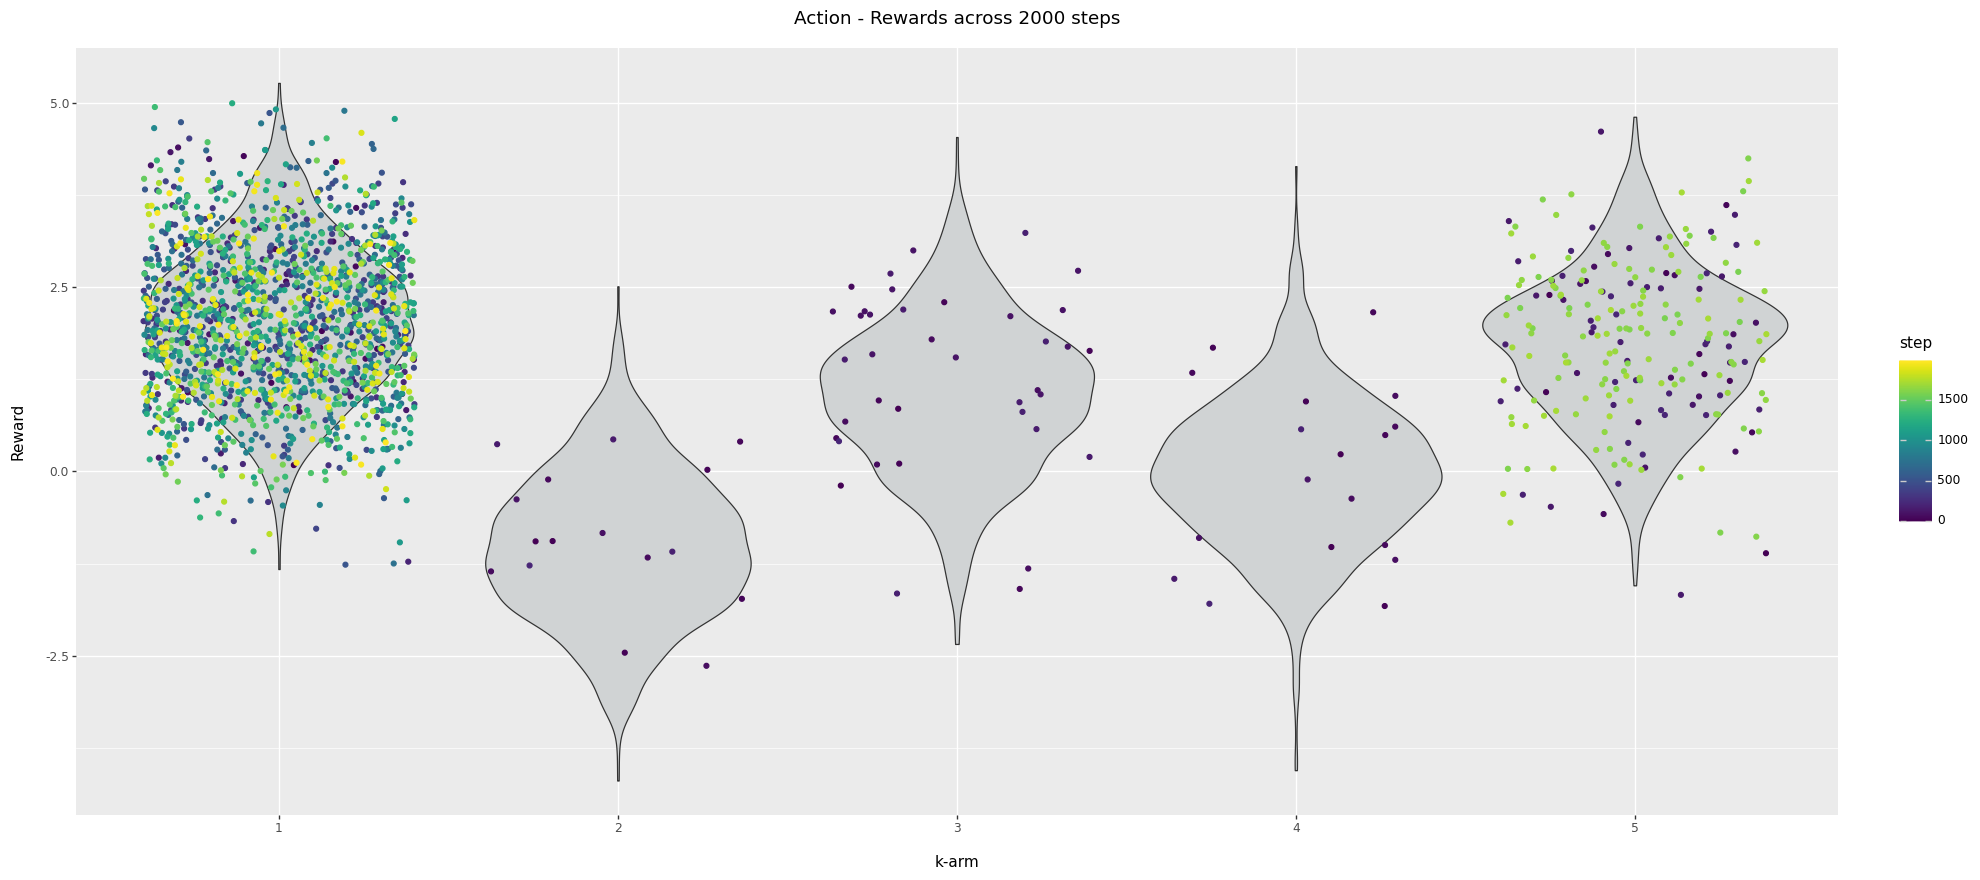

In [30]:
steps_violin_plotter(df_ar, testbed, run=0)

In [10]:
ev_mean = np.zeros(len(EXPECTED_VALUES))
ev_std = np.zeros(len(EXPECTED_VALUES))

In [11]:
ev

array([1.84338531e-316, 0.00000000e+000, 1.62099855e-316, 1.68102793e-316,
       2.37151510e-322])

In [13]:
ev_mean.shape[0]

5

In [2]:
import pandas as pd
import wandb

api = wandb.Api()
entity, project = "josephjnl", "rlbook"
runs = api.runs(entity + "/" + project)

summary_list, config_list, name_list , tag_list = [], [], [], []
for run in runs:
    # .summary contains output keys/values for
    # metrics such as accuracy.
    #  We call ._json_dict to omit large files
    summary_list.append(run.summary._json_dict)

    # .config contains the hyperparameters.
    #  We remove special values that start with _.
    config_list.append({k: v for k, v in run.config.items() if not k.startswith("_")})

    # .name is the human-readable name of the run.
    name_list.append(run.name)

    tag_list.append(run.tags[0])

runs_df = pd.DataFrame(
    {"summary": summary_list, "config": config_list, "name": name_list, "tag": tag_list}

)

In [3]:
runs_df.head()

,summary,config,name,tag
0,{'Reward Distribution': {'_type': 'image-file'...,"{'tag': 'cpu_profile3', 'alpha': 'sample_avera...",spring-wood-60,cpu_profile3
1,{'Reward Distribution': {'_type': 'image-file'...,"{'tag': 'cpu_profile3', 'alpha': 'sample_avera...",brisk-resonance-59,cpu_profile3
2,{'Reward Distribution': {'_type': 'image-file'...,"{'tag': 'cpu_profile3', 'alpha': 'sample_avera...",playful-firefly-58,cpu_profile3
3,{'Reward Distribution': {'_type': 'image-file'...,"{'tag': 'cpu_profile3', 'alpha': 'sample_avera...",wise-frost-57,cpu_profile3
4,{'Reward Distribution': {'_type': 'image-file'...,"{'tag': 'cpu_profile3', 'alpha': 'sample_avera...",quiet-dawn-56,cpu_profile3


In [21]:

# import pandas as pd
# import wandb

# api = wandb.Api()
# entity, project = "josephjnl", "rlbook"
# runs = api.runs(entity + "/" + project)

# summary_list, config_list, name_list , tag_list = [], [], [], []
# for run in runs:
#     if run.tags:
#        run.config["tag"] = run.tags[0]
#        run.update() 

In [4]:
runs_df.iloc[0].summary

{'Reward Distribution': {'_type': 'image-file',
  'format': 'png',
  'height': 900,
  'path': 'media/images/Reward Distribution_1001_7e79f04fd5be73a8bebc.png',
  'sha256': '7e79f04fd5be73a8bebc012b4377a8c71809027541fbe01371ff0b71f2c9bac2',
  'size': 228980,
  'width': 2000},
 '_runtime': 1.29956316947937,
 '_step': 1001,
 '_timestamp': 1728699965.4149292,
 '_wandb': {'runtime': 0},
 'duration (s)': 3.07867,
 'optimal_action_percent': {'last': 0.8065},
 'reward': {'last': 1.4620378201547868}}

In [5]:
runs_df.iloc[0].config

{'tag': 'cpu_profile3',
 'alpha': 'sample_average',
 'n_cpus': 8,
 'p_drift': 0,
 'EpsilonGreedy': 'rlbook.bandits.algorithms.EpsilonGreedy'}

In [23]:
n_cpus, durations, tags = [], [], []

for i, run in runs_df.iterrows():
    if "cpu" in run.tag:
        durations.append(run.summary["duration (s)"])
        tags.append(run.tag)
        n_cpus.append(run.config["n_cpus"])
df = pd.DataFrame({"duration": durations, "tags": tags})

In [24]:
df["tags"].unique()

array(['cpu_profile3', 'cpu_profile2', 'cpu_profile_refactor_v1',
       'cpu_profile'], dtype=object)

In [27]:
df = pd.DataFrame({"n_procs": n_cpus, "duration": durations, "tags": tags})
df["version"] = df["tags"].map(
    {
        "cpu_profile": "v1_original",
        "cpu_profile_refactor_v1": "v2_omegaconf",
        "cpu_profile2": "v3_np_argmax",
        "cpu_profile3": "v4_lazy_logger",
    })

In [28]:
df.head()

,n_procs,duration,tags,version
0,8,3.078670,cpu_profile3,v4_lazy_logger
1,7,3.072784,cpu_profile3,v4_lazy_logger
2,6,3.141549,cpu_profile3,v4_lazy_logger
3,5,3.565302,cpu_profile3,v4_lazy_logger
4,4,4.222982,cpu_profile3,v4_lazy_logger


In [61]:
from plotnine import (
    aes, geom_line, geom_point,
    geom_text, geom_label,
    scale_y_log10, scale_y_continuous
      ggplot, ggtitle, theme, xlab, ylab)

In [68]:
p = (
    ggplot(
        aes(
            x="n_procs",
            y="duration",
            )

    )
    + geom_point(df, aes(color="version"))
    + geom_line(df, aes(color="version"))
    + ylab("Runtime (s)")
    + scale_y_log10(breaks=[3, 10, 30, 100, 500])
)

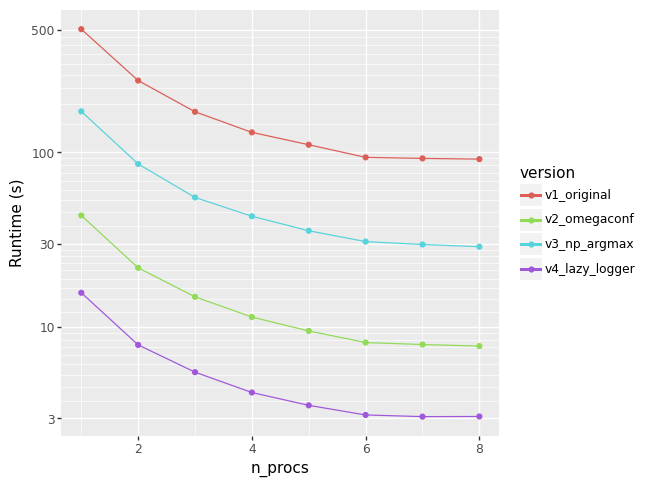

In [69]:
fig = p.draw()
fig
